# Introduction

This notebook will illustrate how to solve a 1-D isothermal compressible fluid flow problem using TensorFlow.

## The 1-D isothermal compressible fluid flow problem

This PDE was selected as an intermediate step for solving the 1-D MHD equations. The fluid equations for isothermal flow of a compressible ideal fluid are the *continuity equation*:

\begin{equation}
    \frac {\partial \rho} {\partial t} + \nabla \cdot (\rho \mathbf u) = 0
\end{equation}

and the *momentum equation*:

\begin{equation}
    \rho \frac {D \mathbf u} {D t} + \nabla \cdot \mathbf P = 0
\end{equation}

where $\rho$ is the mass density, $\mathbf u$ is the fluid velocity, $\mathbf P$ is the pressure tensor (assume isotropic). $D$ is the convective derivative operator:

\begin{equation}
    \frac {D} {D t} = \frac {\partial} {\partial t} + \mathbf u \cdot \nabla
\end{equation}

The density $\rho$ and pressure $P$ are related by the ideal gas law:

\begin{equation}
    P = n k T = \frac {\rho} {m} k T
\end{equation}

where  $n$ is the fluid number denity, $m$ is the mass of a fluid particle, $T$ is the temperature, and $k$ is the Boltzmann constant.

In the case of 1-D flow, these equations reduce to:

\begin{equation}
    \frac {\partial \rho} {\partial t} + \rho \frac {\partial u} {\partial x} + u \frac {\partial \rho} {\partial x} = 0
\end{equation}

\begin{equation}
    \rho \left( \frac {\partial u} {\partial t} + u \frac {\partial u} {\partial x} \right) + \frac {\partial P} {\partial x} = 0
\end{equation}

Rewriting the momentum equation using the ideal gas law:

\begin{equation}
    \rho \left( \frac {\partial u} {\partial t} + u \frac {\partial u} {\partial x} \right) + \frac {k T}{m} \frac {\partial \rho} {\partial x} = 0
\end{equation}

Now assume the following initial conditions, representing an initially motionless uniform fluid at $T = T_0$.

\begin{equation}
    \rho(x > 0, 0) = \rho_0 \\
    u(x, 0) = 0
\end{equation}

At $(x, t) = (0, 0)$, apply a pressure pulse:

\begin{equation}
    P(0, t \gt 0) = P_1
\end{equation}

which can be rewritten as:

\begin{equation}
    \rho(0, t \gt 0) = \frac {m P_1} {k T_0}
\end{equation}

The problem now is to determine the density and velocity profiles over $0 \le x \le 1$ for $t \gt 0$.

## Setting up the problem.

This problem is a system of two 1st-order partial differential equations, for $\rho(x, t)$ and $u(x, t)$. Each quantity can be estimated using a trial function of the form:

\begin{equation}
    \psi_t(x, t) = A(x, t) + P(x, t) N(x, t, \mathbf p)
\end{equation}

where $A(x, t)$ is the boundary condition function, $P(x, t)$ is the network coefficient function, and $N(x, t, \mathbf p)$ is the scalar output of a neural network with inputs $(x, t)$ and parameters $\mathbf p$.

### The boundary condition function $A(x, t)$

For a 1st-order PDE with Dirichlet boundary conditions, the boundary condition function takes the general form:

\begin{equation}
    A(x, t) = (1 - x) f_0(0, t) + x f_1(1, t) \\
    + (1 - t) \{ g_0(x, 0) - [ (1 - x) g_0(0, 0) + x g_0(1, 0) ] \} \\
    + t \{ g_1(x, 1) - [ (1 - x) g_1(0, 1) + x g_1(1, 1) ] \}
\end{equation}

where the boundary conditions are:

\begin{equation}
    f_0(x, t) = \psi(0, t) \\
    f_1(x, t) = \psi(1, t) \\
    g_0(x, t) = \psi(x, 0) \\
    g_1(x, t) = \psi(x, 1) \\
\end{equation}

and $\psi$ is $\rho$ or $u$.

The current problem is an initial value problem, so Dirichlet boundary conditions are only available at $x = 0$ and $t = 0$. Thus we only use $f_0(x, t)$ and $g_0(x, t)$, and the boundary condition function simplifies to:

\begin{equation}
    A(x, t) = (1 - x) f_0(0, t) + (1 - t) \{ g_0(x, 0) - [ (1 - x) g_0(0, 0) + x g_0(1, 0) ] \}
\end{equation}

For the density $\rho$, the boundary conditions are:

\begin{equation}
    f_{0\rho}(x, t) = \rho(0, 0) = \frac {m P_1} {k T_0} \\
    g_{0\rho}(0, t) = \rho(0, 0) = \frac {m P_1} {k T_0} \\
    g_{0\rho}(x \gt 0, t) = \rho(x \gt 0, 0) = \rho_0 \\
\end{equation}

Note that $g_0(x, t)$ is defined piecewise, but is continuous with $f_0(x, t)$ at $(x, t) = (0, 0)$, as required for the boundary condition function.

The corresponding boundary condition function simplifies to:

\begin{equation}
    A_{\rho}(x = 0, t) = \frac {m P_1} {k T_0} \\
    A_{\rho}(x \gt 0, t) = \frac {m P_1} {k T_0} (1 - x) t + \rho_0
\end{equation}

For the velocity $u$, the boundary conditions are:

\begin{equation}
    f_{0u}(x, t) = 0 \\
    g_{0u}(x, t) = 0 \\
\end{equation}

The corresponding boundary condition function is:

\begin{equation}
    A_u(x, t) = 0
\end{equation}

Note that tbe boundary condition functions evaluate to the corresponding boundary condition values at $x = 0$ and/or $t = 0$.

### The network coefficient function $P(x, t)$

The network coefficient function is the same for goth $\rho$ and $u$:

\begin{equation}
    P_{\rho}(x, t) = P_u(x, t) = x t
\end{equation}

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import TensorFlow.
import tensorflow as tf

In [2]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-12-18 10:28:07.935401
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Tue Oct 12 18:33:42 PDT 2021; root:xnu-7195.141.8~1/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [27]:
# Set up the output directory.
eq_name = "1d_fluid"
path = os.path.join(".", eq_name)
output_dir = create_output_directory(path)

In [28]:
# Define the hyperparameters.

# Training optimizer
optimizer_name = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Maximum number of training epochs.
max_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Absolute tolerance for consecutive loss function values to indicate convergence.
tol = 1e-6

# Number of hidden nodes.
H = 10

# Number of dimensions
m = 2

# Number of training points in each dimension.
nx_train = 11
nt_train = 11
n_train = nx_train*nt_train

# Number of validation points in each dimension.
nx_val = 21
nt_val = 21
n_val = nx_val*nt_val

# Random number generator seed.
random_seed = 0

In [29]:
# Create and save the training data.
xt_train = create_training_data(nx_train, nt_train)
x_train = xt_train[::nt_train, 0]
t_train = xt_train[:nt_train, 1]
np.savetxt(os.path.join(output_dir,'xt_train.dat'), xt_train)

# Create and save the validation data.
xt_val = create_training_data(nx_val, nt_val)
x_val = xt_val[::nt_val, 0]
t_val = xt_val[:nt_val, 1]
np.savetxt(os.path.join(output_dir, 'xt_val.dat'), xt_val)

In [52]:
# Define the physical conditions.

# Boltzmann constant
k = 1.38064852e-23  # m2 kg s-2 K-1

# Particle mass (assume H gas)
m = 1.673557692882144e-27 # kg, = 1.00784 u, 1 u = 1.66053906660(50)×10−27 kg

# Temperature
T0 = 300.0 # K

# Pressure (Pa)
P_0 = 101325.0
P_1 = 1.1*P_0

# Mass density (kg/m**3)
rho_0 = m*P_0/(k*T0)
rho_1 = m*P_1/(k*T0)

In [53]:
# Define the differential equations using TensorFlow operations.

@tf.function
def pde1(x, t, rho, u, drho_dx, drho_dt, du_dx, du_dt):
    G = drho_dt + rho*du_dx + u*drho_dx
    return G

@tf.function
def pde2(x, t, rho, u, drho_dx, drho_dt, du_dx, du_dt):
    G = rho*(du_dt + u*du_dx) + k*T0/m*drho_dx
    return G

In [54]:
# Define the trial functions.

@tf.function
def rho_trial(x, t, N):
    A_0 = tf.constant([rho_1], dtype="float64")
    A_tmp = (1 - x)*(rho_0 + (rho_1 - rho_0)*t)
    A = tf.concat([A_0, A_tmp[1:]], axis=0)
    P = x*t
    rho = A + P*N[:, 0]
    return rho

@tf.function
def u_trial(x, t, N):
    A = 0
    P = x*t
    u = A + P*N[:, 0]
    return u

In [55]:
# Build the models.
model_rho = build_model(H, w0_range, u0_range, v0_range)
model_u = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizers.
optimizer_rho = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer_u = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the models.

# Create history variables.
losses1 = []
losses2 = []
losses = []
phist_rho = []
phist_u = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
# shape (n_train, m)
xt_train_var = tf.Variable(xt_train, name="xt_train")

# Clear the convergence flag to start.
converged = False

# Alias variables for convenience.
xt = xt_train_var
x = xt[:, 0]
t = xt[:, 1]

print("Hyperparameters: n_train = %s, H = %s, max_epochs = %s, optimizer = %s, learning_rate = %s"
      % (n_train, H, max_epochs, optimizer_name, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(max_epochs):

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape(persistent=True) as tape0:

            # Compute the network outputs at the training points.
            N_rho = model_rho(xt)
            N_u = model_u(xt)

            # Compute the trial solutions.
            Y_rho = rho_trial(x, t, N_rho)
            Y_u = u_trial(x, t, N_u)

        # Compute the gradients of the trial solutions wrt inputs.
        delY_rho = tape0.gradient(Y_rho, xt)
        dY_rho_dx = delY_rho[:, 0]
        dY_rho_dt = delY_rho[:, 1]
        delY_u = tape0.gradient(Y_u, xt)
        dY_u_dx = delY_u[:, 0]
        dY_u_dt = delY_u[:, 1]

        # Compute the estimates of the differential equations.
        G1 = pde1(x, t, Y_rho, Y_u, dY_rho_dx, dY_rho_dt, dY_u_dx, dY_u_dt)
        G2 = pde2(x, t, Y_rho, Y_u, dY_rho_dx, dY_rho_dt, dY_u_dx, dY_u_dt)

        # Compute the loss functions.
        L1 = tf.math.sqrt(tf.reduce_sum(G1**2)/n_train)
        L2 = tf.math.sqrt(tf.reduce_sum(G2**2)/n_train)
        L = L1 + L2

    # Save the current losses.
    losses1.append(L1.numpy())
    losses2.append(L2.numpy())
    losses.append(L.numpy())

    # Check for convergence.
    if epoch > 0:
        loss_delta = losses[-1] - losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break

    # Compute the gradient of the loss function wrt the network parameters.
    pgrad_rho = tape1.gradient(L, model_rho.trainable_variables)
    pgrad_u = tape1.gradient(L, model_u.trainable_variables)

    # Save the parameters used in this epoch.
    phist_rho.append(
        np.hstack(
            (model_rho.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model_rho.trainable_variables[1].numpy(),       # u (H,) row vector
             model_rho.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )
    phist_u.append(
        np.hstack(
            (model_u.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model_u.trainable_variables[1].numpy(),       # u (H,) row vector
             model_u.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this epoch.
    optimizer_rho.apply_gradients(zip(pgrad_rho, model_rho.trainable_variables))
    optimizer_u.apply_gradients(zip(pgrad_u, model_u.trainable_variables))

    # if epoch % 100 == 0:
    print("Ending epoch %s, loss function = %s" % (epoch, L.numpy()))

# Save the parameters used in the last epoch.
phist_rho.append(
    np.hstack(
        (model_rho.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model_rho.trainable_variables[1].numpy(),       # u (H,) row vector
         model_rho.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)
phist_u.append(
    np.hstack(
        (model_u.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model_u.trainable_variables[1].numpy(),       # u (H,) row vector
         model_u.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

n_epochs = epoch + 1

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())
print("Epochs: %d" % n_epochs)
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist_rho.dat'), np.array(phist_rho))
np.savetxt(os.path.join(output_dir, 'phist_u.dat'), np.array(phist_u))

Hyperparameters: n_train = 121, H = 10, max_epochs = 1000, optimizer = Adam, learning_rate = 0.01
Training started at 2021-12-18 10:50:12.642735
Ending epoch 0, loss function = 165.37341242183163
Ending epoch 1, loss function = 1679.9432136190358
Ending epoch 2, loss function = 1523.100895761721
Ending epoch 3, loss function = 804.3954400851202
Ending epoch 4, loss function = 127.76432280711593
Ending epoch 5, loss function = 431.0998761111261
Ending epoch 6, loss function = 351.4569875539257
Ending epoch 7, loss function = 24.926578349312326
Ending epoch 8, loss function = 471.7674326547262
Ending epoch 9, loss function = 665.9806959560946
Ending epoch 10, loss function = 626.1612968611304
Ending epoch 11, loss function = 407.3755937313436
Ending epoch 12, loss function = 52.79105510477084
Ending epoch 13, loss function = 408.6843979023833
Ending epoch 14, loss function = 643.1598919442648
Ending epoch 15, loss function = 687.8300928707787
Ending epoch 16, loss function = 579.59308309

In [56]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape0:
    N_rho = model_rho(xt)
    N_u = model_u(xt)
    rho_train = rho_trial(x, t, N_rho)
    u_train = u_trial(x, t, N_u)
delrho = tape0.gradient(rho_train, xt)
drho_dx_train = delrho[:, 0]
drho_dt_train = delrho[:, 1]
delu = tape0.gradient(u_train, xt)
du_dx_train = delu[:, 0]
du_dt_train = delu[:, 1]

np.savetxt(os.path.join(output_dir, 'rho_train.dat'), rho_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'drho_dx_train.dat'), drho_dx_train.numpy())
np.savetxt(os.path.join(output_dir, 'drho_dt_train.dat'), drho_dt_train.numpy())

np.savetxt(os.path.join(output_dir, 'u_train.dat'), u_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'du_dx_train.dat'), du_dx_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'du_dt_train.dat'), du_dt_train.numpy().reshape((n_train)))

# # Compute and save the analytical solution and derivatives at training points.
# Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
# dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
# dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
# d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xy) for xy in xy_train])
# d2Ya_dy2_train = np.array([eq.d2Ya_dy2(xy) for xy in xy_train])
# np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
# np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
# np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)
# np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
# np.savetxt(os.path.join(output_dir,'d2Ya_dy2_train.dat'), d2Ya_dy2_train)

# # Compute and save the error in the trained solution and derivatives at training points.
# Yt_err_train = Yt_train.numpy() - Ya_train
# dYt_dx_err_train = dYt_dx_train.numpy() - dYa_dx_train
# dYt_dy_err_train = dYt_dx_train.numpy() - dYa_dy_train
# d2Yt_dx2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dx2_train
# d2Yt_dy2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dy2_train
# np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
# np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
# np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)
# np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
# np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_train.dat'), d2Yt_dy2_err_train)

# # Compute the final RMS errors.
# Yt_rmse_train = np.sqrt(np.sum(Yt_err_train**2)/n_train)
# print("Yt_rmse_train = %s" % Yt_rmse_train)

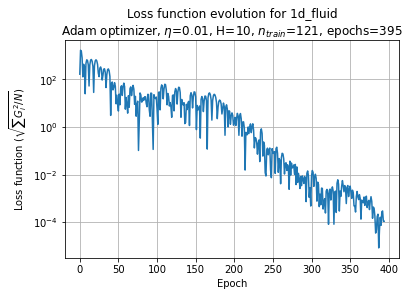

In [57]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()

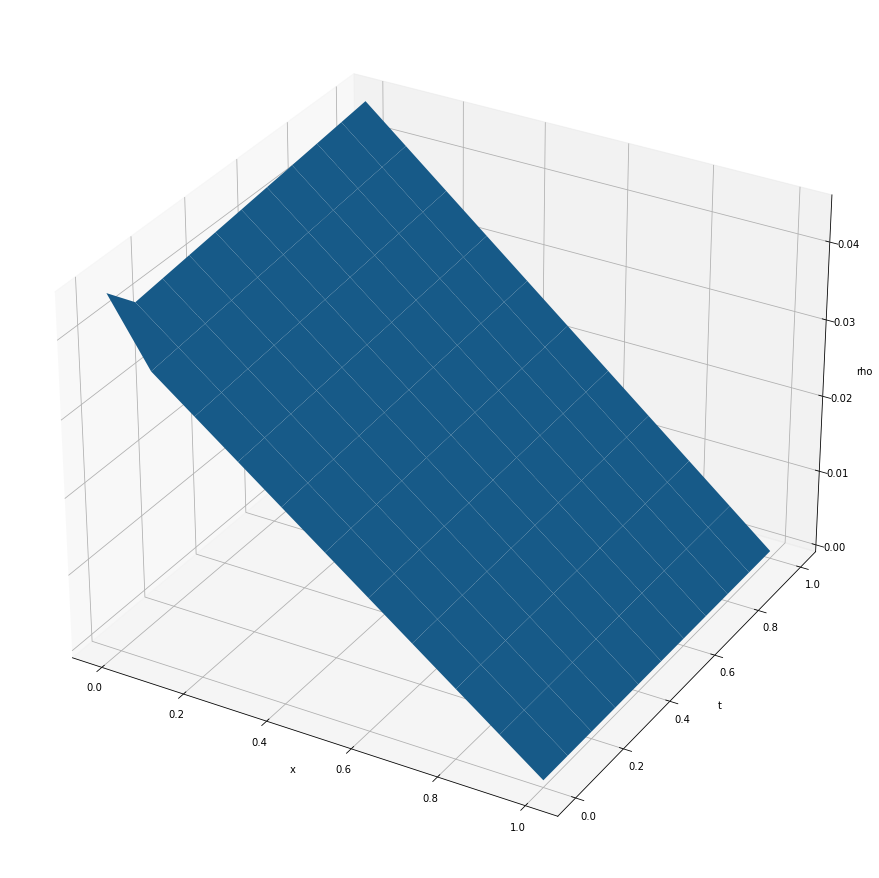

In [63]:
# Plot the trained solutions.
fig = plt.figure(figsize=(12, 14))

# rho
plt.subplot(211)
Z = rho_train.numpy().reshape((nx_train, nt_train)).T
(X, Y) = np.meshgrid(x_train, t_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('rho')
plt.show()

# u
# plt.subplot(212)
# Z = u_train.numpy().reshape((nx_train, nt_train)).T
# (X, Y) = np.meshgrid(x_train, t_train)
# ax = Axes3D(fig, auto_add_to_figure=False)
# fig.add_axes(ax)
# ax.plot_surface(X, Y, Z)
# ax.set_xlabel('x')
# ax.set_ylabel('t')
# ax.set_zlabel('u')
# plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = Yt_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dx_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial x-\partial \psi_a(x,y)/\partial x$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dy_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial y-\partial \psi_a(x,y)/\partial y$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

In [ ]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

In [ ]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

In [ ]:
# Plot the parameter histories.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, epoch + 1))
plt.subplots_adjust(hspace=0.2)
plt.show()